<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/DzDatascience/dz13_ultraPro_keras_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
# Ваше решение
# загружаем библиотеку для работы с массивами данных
import numpy as np
 # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import matplotlib.pyplot as plt
# более высокоуровневое API на базе библиотеки matplotlib
import seaborn as sns
# загружаем библиотеку tensorflow и её модули
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense,concatenate,Conv2DTranspose,multiply  # загружаем необходимые слои(входной, полносвязный)
from tensorflow.keras.layers import BatchNormalization, Dropout,Conv2D,MaxPooling2D, Flatten, Reshape, Lambda,Conv1D,MaxPooling1D # загружаем слои(нормализации, регуляризации и т.д)
from tensorflow.keras.models import Model,Sequential # загружаем абстрактный класс базовой модели сети от кераса
# Загружаем библиотеку для работы с изображениями
from PIL import Image


In [ ]:
# Подключение модуля для загрузки данных из облака
import gdown

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

'middle_fmr.zip'

In [ ]:
# Разархивация датасета в директорию 'content/cars'
!unzip -qo "middle_fmr.zip" -d /content/cars

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/cars/'

In [ ]:
# Для работы с файлами
import os

os.listdir(IMAGE_PATH)

['Ferrari', 'Renault', 'Mercedes']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [ ]:
i = 1

# Формирование пути к выборке одной марки авто
f'{IMAGE_PATH}{CLASS_LIST[i]}/'

'/content/cars/Mercedes/'

Теперь можно получить списки файлов для всех классов:

In [ ]:
for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Ferrari : ['car_Ferrari__981.png', 'car_Ferrari__809.png', 'car_Ferrari__1285.png', 'car_Ferrari__706.png', 'car_Ferrari__150.png', 'car_Ferrari__332.png', 'car_Ferrari__64.png', 'car_Ferrari__760.png', 'car_Ferrari__560.png', 'car_Ferrari__625.png', 'car_Ferrari__635.png', 'car_Ferrari__603.png', 'car_Ferrari__552.png', 'car_Ferrari__555.png', 'car_Ferrari__110.png', 'car_Ferrari__1188.png', 'car_Ferrari__1150.png', 'car_Ferrari__1028.png', 'car_Ferrari__722.png', 'car_Ferrari__848.png', 'car_Ferrari__772.png', 'car_Ferrari__881.png', 'car_Ferrari__218.png', 'car_Ferrari__1287.png', 'car_Ferrari__1049.png', 'car_Ferrari__1260.png', 'car_Ferrari__452.png', 'car_Ferrari__123.png', 'car_Ferrari__401.png', 'car_Ferrari__290.png', 'car_Ferrari__43.png', 'car_Ferrari__585.png', 'car_Ferrari__258.png', 'car_Ferrari__302.png', 'car_Ferrari__208.png', 'car_Ferrari__819.png', 'car_Ferrari__254.png', 'car_Ferrari__300.png', 'car_Ferrari__446.png', 'car_Ferrari__280.png', 'car_Ferrari__234.png', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции imshow() из модуля matplotlib.pyplot).

Для этого импортируем необходимые библиотеки, создадим заготовку для изображений всех классов.

Далее в цикле переберем все классы. Сформируем путь к классу, выберем из него один случайный экземпляр (при помощи функции random.choice()) и отобразим его в ячейке (получим содержимое картинки при помощи функции open() из модуля Image).

In [ ]:
from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Отрисовка графиков

%matplotlib inline

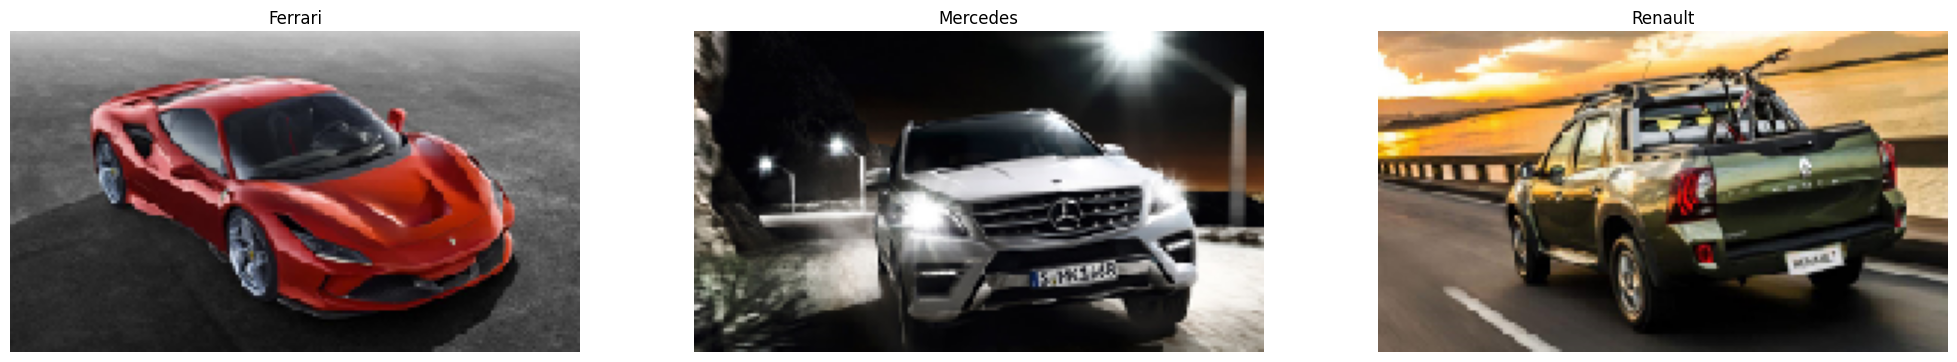

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

Создание списков файлов и их меток класса
Чтобы создать обучающую базу, вам понадобится список всех картинок машин, а также список номеров (меток) класса для них в том же порядке. То есть, например, для пятого по порядку файла в списке файлов метка его класса будет пятой в списке меток.

Сейчас фотографии машин каждого класса лежат в отдельных папках. Загружая фотографию машины, вы можете сразу записывать порядковый номер папки как метку класса машины в соответствующий список.

Количество классов равно CLASS_COUNT – уже было вычислено ранее.

По аналогии с тем, как выше осматривалось содержимое папок, вы можете, получив имена файлов фотографий, собрать их в список data_files, а в список data_labels - собрать номера (метки) классов один за другим:

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} машин')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Ferrari составляет 1088 машин
Размер класса Mercedes составляет 1161 машин
Размер класса Renault составляет 1178 машин
Общий размер базы для обучения: 3427


In [ ]:
print('Пути к файлам: ', data_files[1085:1090])
print('Их метки классов:', data_labels[1085:1090])

In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 128                           # Ширина изображения
IMG_HEIGHT = 64                           # Высота изображения

In [ ]:
import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

Работа с keras.preprocessing.image_dataset_from_directory

Выборка готова. В керас есть полезный метод image_dataset_from_directory . Он позволяет превратить выборку на диске в tf.data.Dataset всего в пару строк кода.

In [ ]:
# Задаём параметры для tf.data.Dataset
batch_size = 32
img_height = 64
img_width = 128
data_dir = '/content/cars/'

Создаём объект обучающей выборки на основе изображений на диске. Обратите внимание что мы можем сразу разделить выборки на обучающую и тестовую/проверочную и они не будут пересекаться , в случае если мы зададим параметры validation_split и seed одинаковыми значениями(И тестовый и обучающий набор разделятся одинаково случайно в равных долях).

In [ ]:
Train_gen = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=877,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3427 files belonging to 3 classes.
Using 2742 files for training.


Создаём объект проверочной выборки



In [ ]:
Test_gen = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=877,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3427 files belonging to 3 classes.
Using 685 files for validation.


Теперь можем посмотреть чем являются объекты которые возвращает наша выборка - это пакет изображений(уже сконвертированных в нужный формат) в количестве batch_size штук. И Метки классов к этим изображениям , так же в количестве batch_size штук.

In [ ]:
for imgs, labels in Train_gen:
  pass
print(imgs.shape)
print(labels.shape)

(22, 64, 128, 3)
(22,)


Создадим простую модель для классификации и обучим её на нашем датасете

In [ ]:
model = Sequential()

model.add(Conv2D(8, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense (1, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(Train_gen, validation_data=Test_gen, epochs=10, verbose= 1)

Epoch 1/10
86/86 [==============================] - 4s 32ms/step - loss: -68775.5938 - accuracy: 0.3428 - val_loss: -386736.8125 - val_accuracy: 0.3226
Epoch 2/10
86/86 [==============================] - 4s 42ms/step - loss: -1916405.0000 - accuracy: 0.3428 - val_loss: -5375548.0000 - val_accuracy: 0.3226
Epoch 3/10
86/86 [==============================] - 3s 30ms/step - loss: -13938931.0000 - accuracy: 0.3428 - val_loss: -30743988.0000 - val_accuracy: 0.3226
Epoch 4/10
86/86 [==============================] - 3s 30ms/step - loss: -53312324.0000 - accuracy: 0.3428 - val_loss: -95366088.0000 - val_accuracy: 0.3226
Epoch 5/10
86/86 [==============================] - 4s 41ms/step - loss: -142620304.0000 - accuracy: 0.3428 - val_loss: -240893360.0000 - val_accuracy: 0.3226
Epoch 6/10
86/86 [==============================] - 3s 30ms/step - loss: -320397440.0000 - accuracy: 0.3428 - val_loss: -496879616.0000 - val_accuracy: 0.3226
Epoch 7/10
86/86 [==============================] - 3s 30ms/s

пробуем генератор и аугументацию

Работа с ImageDataGenerator

ImageDataGenerator это довольно похожий метод обработки данных.Он также позволяет перевести изображения в готовый для работы датасет, однако его задача не столько структурировать данные сколько преобразовать их с помощью встроенных методов и аугментировать таким образом выборку.

Для начала, создадим объект класса ImageDataGenerator с необходимыми параметрами.

Параметрами здесь выступают настройки того, как будет изменяться изображение:

featurewise_center=False Если True, то выводит контур изображения усредняя данные по всему набору.

samplewise_center=False Если True, то выводит контур изображения усредняя данные по элементу.

* featurewise_std_normalization=False* Если True, то делит каждый элемент входного набора данных на сренеквадратическое отклонение по всему набору.

samplewise_std_normalization=False Если True, то делит каждый элемент входного набора данных на сренеквадратическое отклонение этого элемента.

zca_whitening=False Если True, то применяется ZCA-отбеливание.

zca_epsilon=1e-06 эпсилон для ZCA-фильтров [3]. По умолчанию 1e-6.

* rotation_range=0* Значение (в градусах) для выбора случайного поворота изображения.

width_shift_range=0.0 Задает случайный сдвиг по ширине.

height_shift_range=0.0 Задает случайный сдвиг по высоте.

brightness_range=None Задает диапазон выбора сдвига по яркости

shear_range=0.0 Задает диапазон сдвига пикселей изображения (угол сдвига в градусах в направлении против часовой стрелки)

zoom_range=0.0 Диапазон случайного выбора масштабирования изображения

channel_shift_range=0.0 Диапазон случайного сдвига каналов

fill_mode='nearest' каким методом заполнить точки за пределами границы входных изображений
cval=0.0 Значение для точек за пределами границы изображения, когда fill_mode = "constant"

horizontal_flip=False Если True, то выполняется случайный горизонтальный флип изображений (поворот относительно оси y на 180°; ось проходит через центр изображения).

vertical_flip=False Если True, то выполняется случайный вертикальный флип изображений (поворот относительно оси x на 180°; ось проходит через центр изображения).

rescale=None Если None или 0, масштабирование не выполняется, в противном случае данные умножаются на rescale (после всех преобразований)

preprocessing_function=None функция, которая будет применена к каждому изображению. Функция выполняется после всех преобразований
data_format="channels_last" .

"channels_last" означает, что изображение должно иметь следующую форму: (samples, height, width, channels)

validation_split=0.0 Доля изображений, резервируемая для оценки качества модели (число между 0 и 1)

dtype=None Тип данных для генерируемых массивов

In [ ]:
# Задаём параметры для ImageDataGenerator
batch_size = 32
img_height = 128
img_width = 64
data_dir = '/content/cars/'

Для примера создадим генератор который будет случайно поворачивать изображение до 12 градусов, случайно сдвигает его по горизонтали и вертикали на 5 пикселей, укрупнять или уменьшать его на 20% и генерировать изображения в выборки в соотношении 80% обучающая, 20% проверочная.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=5.0,
    height_shift_range=5.0 ,
    zoom_range=0.2,
    validation_split=0.2)

Теперь из этого генератора создадим экземпляры обучающего датагенератора и проверочного. Сразу посмотрим что они генерируют

Здесь используем datagen.flow_from_directory так как изображения у нас хранятся на диске. Если изображения уже подгружены в рабочую среду то можно использовать datagen.flow(x_train, y_train, batch_size=32, subset='training')

Found 2743 images belonging to 3 classes.
Found 684 images belonging to 3 classes.


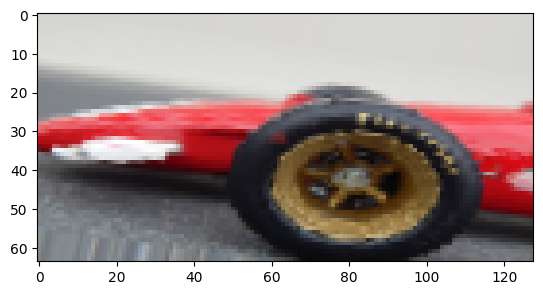

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir,                            # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки.
    shuffle=False,                       # Перемешивание выборки
    subset='training'                    # устанавливаем как набор для обучения
)
val_generator = datagen.flow_from_directory(
    data_dir,                            # Путь ко всей выборке выборке
    target_size=(img_width, img_height), # Размер изображений
    batch_size=batch_size,               # Размер batch_size
    class_mode='categorical',            # Категориальный тип выборки.
    shuffle=False,                       # Перемешивание выборки
    subset='validation'                  # устанавливаем как набор для обучения
)
for  imgs, labels in train_generator:
  plt.imshow(imgs[0].astype("uint8"))
  plt.show()
  break

Теперь построим тестовую модель и обучим её на данных из нашего генератора.

steps_per_epoch - необязательный параметр который указывает сколько раз нужно обратиться модели к генератору за получением новых данных. Может быть полезным когда данных на диске у вас очень много и простая передача по bath_size примеров может длиться очень долго.

In [ ]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense (3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // batch_size,
                              validation_data=val_generator,
                              validation_steps = val_generator.samples // batch_size,
                              epochs=10,
                              verbose= 1)

Epoch 1/10


<ipython-input-42-403c6da09448>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


85/85 [==============================] - 13s 138ms/step - loss: 365.8251 - accuracy: 0.4091 - val_loss: 1.0538 - val_accuracy: 0.4613
Epoch 2/10
85/85 [==============================] - 11s 131ms/step - loss: 1.0115 - accuracy: 0.4814 - val_loss: 0.9785 - val_accuracy: 0.4940
Epoch 3/10
85/85 [==============================] - 11s 130ms/step - loss: 0.9788 - accuracy: 0.4854 - val_loss: 0.9781 - val_accuracy: 0.5104
Epoch 4/10
85/85 [==============================] - 11s 125ms/step - loss: 0.9450 - accuracy: 0.5179 - val_loss: 0.9813 - val_accuracy: 0.5357
Epoch 5/10
85/85 [==============================] - 12s 138ms/step - loss: 0.9293 - accuracy: 0.5183 - val_loss: 0.9840 - val_accuracy: 0.5283
Epoch 6/10
85/85 [==============================] - 12s 138ms/step - loss: 0.9033 - accuracy: 0.5478 - val_loss: 1.0098 - val_accuracy: 0.4940
Epoch 7/10
85/85 [==============================] - 12s 137ms/step - loss: 0.9100 - accuracy: 0.5397 - val_loss: 1.0027 - val_accuracy: 0.5030
Epoch 8/

In [ ]:
num = 0
for x,y in train_generator:
    if  num == 0:
       x_train = x
       y_train = y
    else:
       x_train = np.concatenate([x_train,x])
       y_train = np.concatenate([y_train,y])
    num += 1
    if  num == 100:
      break


print(x_train.shape) # Размер выборок
print(y_train.shape)

(3191, 64, 128, 3)
(3191, 3)


Создадим новые генераторы с использованием datagen.flow

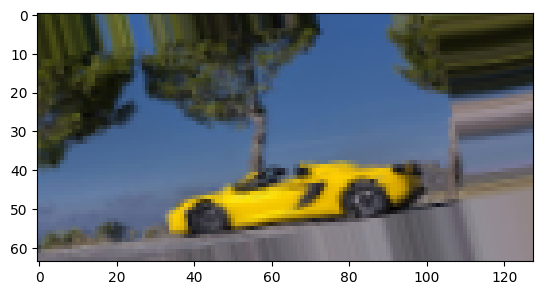

In [ ]:
train_generator_new = datagen.flow(
    x_train, y_train,                           # Путь ко всей выборке выборке
    batch_size=batch_size,                      # Размер batch_size
    subset='training'                           # устанавливаем как набор для обучения
    )
val_generator_new = datagen.flow(
    x_train, y_train,                          # Путь ко всей выборке выборке
    batch_size=batch_size,                     # Размер batch_size
    subset='validation'                        # устанавливаем как набор для обучения
)
for  imgs, labels in train_generator_new:
  plt.imshow(imgs[0].astype("uint8"))
  plt.show()
  break

Протестируем генераторы в модели

In [ ]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense (3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator_new,
                              validation_data=val_generator_new,
                              epochs=60,
                              verbose= 1)

Epoch 1/60


<ipython-input-48-4894009c49c7>:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator_new,


80/80 [==============================] - 8s 81ms/step - loss: 120.3763 - accuracy: 0.4430 - val_loss: 0.9216 - val_accuracy: 0.4906
Epoch 2/60
80/80 [==============================] - 7s 91ms/step - loss: 0.9568 - accuracy: 0.5116 - val_loss: 0.8660 - val_accuracy: 0.5188
Epoch 3/60
80/80 [==============================] - 8s 98ms/step - loss: 0.9102 - accuracy: 0.5637 - val_loss: 1.0558 - val_accuracy: 0.5016
Epoch 4/60
80/80 [==============================] - 6s 80ms/step - loss: 0.9132 - accuracy: 0.5429 - val_loss: 1.0577 - val_accuracy: 0.4639
Epoch 5/60
80/80 [==============================] - 7s 91ms/step - loss: 0.8970 - accuracy: 0.5707 - val_loss: 1.0056 - val_accuracy: 0.4890
Epoch 6/60
80/80 [==============================] - 6s 81ms/step - loss: 0.8844 - accuracy: 0.5691 - val_loss: 0.9065 - val_accuracy: 0.5549
Epoch 7/60
80/80 [==============================] - 6s 79ms/step - loss: 0.8778 - accuracy: 0.5766 - val_loss: 1.1890 - val_accuracy: 0.4044
Epoch 8/60
80/80 [====

43 эпоха: 72,226 %